In [ ]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate

import random

tf.compat.v1.disable_eager_execution()

seed = 1234
env = gym.make("CartPole-v1")
env.seed(seed)

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability
decay_rate = 0.00001            # exponential decay rate for exploration prob

gamma = 0.99

num_episodes = 400

hidden_size = 32

lr = .001

max_utility = 1/(1-gamma)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


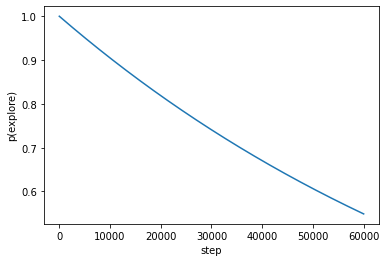

In [ ]:
plt.plot(np.exp(-decay_rate*np.arange(num_episodes*20)))
# plt.plot(explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*np.arange(20000)))
plt.xlabel('step')
plt.ylabel('p(explore)')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import math

from matplotlib import rc
rc('animation', html='jshtml')

def points_within_radius(r):
    points = []
    for i in range(-r, r + 1):
        for j in range(-r, r + 1):
            distance = math.sqrt((i) ** 2 + (j) ** 2)
            if distance <= r:
                points.append((i, j))
    return points



class Environment():
    """ Environment class to introduce noise when measured """
    def __init__(self, environment_array):
        self.array = environment_array
        self.width = len(self.array)
        self.length = len(self.array[0])

    def measure_spot(self, x, y):
        return self.array[x, y] + np.random.normal(scale=30)

class DroneMap():
    """ Drone Map class to handle comparing measurements to existing data """
    def __init__(self, environment):
        # Zeros array same size as the environment
        self.width = environment.width
        self.length = environment.length
        self.map = np.zeros((self.width, self.length))
        # Keep a history of measurements made at each point
        self.measurements = {}
        self.locations = {}

    def get_locations_map(self):
        out_map = self.map.copy()
        for id in self.locations.keys():
            x, y = self.locations[id]
            out_map[x, y] = -500
        return out_map

    def update_spot(self, x, y, measurement, id):
        # Add measurement to list of measurements at that spot
        if not (x, y) in self.measurements.keys():
            self.measurements[(x, y)] = []
        self.measurements[(x, y)].append(measurement)

        if self.map[x, y] == 0:
            self.map[x, y] = measurement
        else:
            # TODO: better system of comparing current map data to measurement, instead of just averaging them
            self.map[x, y] = np.average(self.measurements[(x, y)])
        self.locations[id] = (x, y)

    def indicate_drone_position(self, x, y):
        self.map[x, y] = -500

    def revert_saved_value(self, x, y, value):
        self.map[x, y] = value


class Drone():
    def __init__(self, environment, start, map_agent, id):
        self.id = id
        # TODO: x_icp, and x_komonfilter combines x_odometer and x_icp to give the actual percieved location
        self.x_actual = start[0] # Drone's true position x
        self.y_actual = start[1] # Drone's true position y
        self.x_odom = start[0] # where the drone think's it is based on movements
        self.y_odom = start[1] # where the drone think's it is based on movements

        self.env = environment
        self.found = False # Has the drone has found the target yet
        self.turns = [(0,-1), (-1,0), (0,1), (1,0)] # All 4 2d directions in clockwise order
        self.facing = (0,1) # Direction the drone is facing

        self.map = map_agent
        self.traversed = np.zeros((self.env.length, self.env.width+1))

        # Variable to save a map value when indicating drone's location
        self.saved_value = 0
        self.odometry_noise = 0.25
        self.measurement_interval = 5
        self.measurement_interval_timer = self.measurement_interval

    def get_map(self):
        return self.map.map

    def observe_local_radius(self, r):
        points = points_within_radius(r)
        for p in points:
            self.measure_spot(p[0], p[1])

    def move(self, currDir):
        if self.found:
            return

        # Take a sonar measurement at intervals
        if self.measurement_interval_timer <= 0:
            self.observe_local_radius(5)
            self.measurement_interval_timer = self.measurement_interval
        else:
            self.measurement_interval_timer -= 1

        # Check/map spots around and then move to the best one
        self.take_spot(currDir)
        if self.x_odom > 99:
          self.x_odom = 99
        if self.y_odom > 99:
          self.y_odom = 99
        if self.x_odom < 0:
          self.x_odom = 0
        if self.y_odom < 0:
          self.y_odom = 0
        if self.x_actual > 99:
          self.x_actual = 99
        if self.y_actual > 99:
          self.y_actual = 99
        if self.x_actual < 0:
          self.x_actual = 0
        if self.y_actual < 0:
          self.y_actual = 0
        self.traversed[self.x_odom, self.y_odom] = 20 + self.traversed[self.x_odom, self.y_odom]
        return

    def take_spot(self, d):
        self.x_actual = self.x_actual + d[0]
        self.y_actual = self.y_actual + d[1]
        self.x_odom = self.x_odom + d[0]
        self.y_odom = self.y_odom + d[1]
        # TODO: add noise to odometry movement
        if np.random.rand() <= self.odometry_noise:
            # Either go a bit farther or a bit shorter than we thought
            if np.random.rand() <= 0.5:
                self.x_actual = self.x_actual + d[0]
                self.y_actual = self.y_actual + d[1]
            else:
                self.x_actual = self.x_actual - d[0]
                self.y_actual = self.y_actual - d[1]
        self.facing = d

    def check_spots(self):
        """ Check all adjacent spots and get penalties for moving to each """
        surroundings = {}
        trn = self.turns.index(self.facing) - 1 # Always try to turn left first
        for i in range(4): # Try moving left, straight, right, backwards
            d = self.turns[(i + trn) % 4] # direction to try
            measurement = self.measure_spot(d[0], d[1]) # Returns value or None if spot is off the map
            if measurement:
                # Compare current altiture to measured location
                surroundings[d] = (measurement - self.map.map[self.x_odom, self.y_odom])**2
                # Add a penalty for traversing a spot multiple times
                surroundings[d] = surroundings[d] + self.traversed[self.x_odom + d[0], self.y_odom + d[1]]**2
            else:
               surroundings[d] = -1 # Spot was not moveable
        return surroundings

    def measure_spot(self, x_d, y_d) -> (float or None):
        """ Measure the spot (x, y), update the map with the spot and return most up to date measurement from map """
        # Make sure the space is on the map
        if ((self.x_actual + x_d) < 0) or ((self.x_actual + x_d) > (self.map.length-1)):
            return None
        if ((self.x_odom + x_d) < 0) or ((self.x_odom + x_d) > (self.map.length-1)):
            return None
        if ((self.y_actual + y_d) < 0) or ((self.y_actual + y_d) > (self.map.width-1)):
            return None
        if ((self.y_odom + y_d) < 0) or ((self.y_odom + y_d) > (self.map.width-1)):
            return None

        # Value of the spot we are checking
        measurement = self.env.measure_spot(self.x_actual + x_d, self.y_actual + y_d)
        self.map.update_spot(self.x_odom + x_d, self.y_odom + y_d, measurement, self.id)
        return self.map.map[self.x_odom + x_d, self.y_odom + y_d] # Our most up to date measurement

def compare_map_to_environment(mapping_agent, environment):
    map_grid = mapping_agent.map
    diff = map_grid - environment.array
    return np.linalg.norm(diff) # Euclidean distance, sum of squared differences

import csv
max_x = 0
max_y = 0
environment_grid = np.zeros(((201,201)))
with open('interpolated_elevation_data.csv', mode ='r')as file:
    csvFile = csv.reader(file)
    for line in list(csvFile)[1:]:
        x = int(float(line[0])//1)
        y = int(float(line[1])//1)
        val = float(line[2])
        environment_grid[x,y] = val
        if x > max_x:
            max_x = x
        if y > max_y:
            max_y = y

# Initialize Environment and Agents
def env_init(num_drones = 20):
  environment = Environment(environment_grid[90:190,90:190])
  mapping_agent = DroneMap(environment)
  drones = []
  for i in range(num_drones):
      start = (100*np.random.rand((2))).astype(int)
      drones.append(Drone(environment, start, mapping_agent, i))
  return environment, mapping_agent, drones


In [ ]:
from tqdm.notebook import trange

observation_size = 4
num_actions = 2

def make_model():

    states = layers.Input(shape=(100,100,1))
    dronePos = layers.Input(shape=(100,100,1))
    merged = Concatenate()([dronePos, states])
    conv1 = Conv2D(50,5,padding='valid',activation='relu')(merged)
    pool1 = MaxPooling2D(2,2)(conv1)

    # second convolution and pooling
    conv2 = Conv2D(20,5,padding='valid',activation='relu')(pool1)
    pool2 = MaxPooling2D(2,2)(conv2)

    # flatten into vector
    flattened = Flatten()(pool2)

    # fully connected layer
    dense = Dense(200,activation='relu')(flattened)
    hidden = layers.Dense(hidden_size,activation='relu')(dense)
    Qs = layers.Dense(4)(hidden)

    qnetwork = keras.Model(inputs=[states, dronePos],outputs=Qs)

    actions = layers.Input(shape=(1),dtype='int32')
    discounted_sums = layers.Input(shape=(1))
    loss = keras.losses.MeanSquaredError()(discounted_sums,tf.gather_nd(Qs,actions,batch_dims=1))

    training_qnetwork = keras.Model(inputs=[states,actions,discounted_sums,dronePos],outputs=Qs)
    training_qnetwork.add_loss(loss)

    return training_qnetwork, qnetwork

training_qnetwork, qnetwork = make_model()

optimizer = keras.optimizers.legacy.Adam(learning_rate=lr)

training_qnetwork.compile(optimizer=optimizer)

loss_history = []

step = 1

for ep in trange(1,num_episodes+1):

  environment, mapping_agent, drones = env_init(1)

  state = np.expand_dims(mapping_agent.map,axis=-1)
  dronePos = np.zeros((100, 100, 1))
  for d in drones:
    dronePos[d.y_odom, d.x_odom, 0] = 1
  states = []
  actions = []
  rewards = []
  new_states = []
  positions = []

  steps_in_episode = 0
  while True:
    # select action using epsilon-greedy policy
    explore_p = np.exp(-decay_rate*step)
    if explore_p > np.random.rand():
        action = random.randint(0,3)
    else:
        Qs = qnetwork.predict([state[None,...], dronePos[None,...]])[0]
        action = np.argmax(Qs)
    states.append(state)
    positions.append(dronePos)
    # apply state to get new state, reward, and done flag
    for d in drones:
      if action == 0:
        d.move([0, 1])
      if action == 1:
        d.move([0, -1])
      if action == 2:
        d.move([1, 0])
      if action == 3:
        d.move([-1, 0])
    new_state = np.expand_dims(mapping_agent.map,axis=-1)
    dronePos = np.zeros((100, 100, 1))
    for d in drones:
      dronePos[d.y_odom, d.x_odom, 0] = 1
    reward = -compare_map_to_environment(mapping_agent, environment)

    # record transition
    actions.append(action)
    rewards.append(reward)
    new_states.append(new_state)

    # update state
    state = new_state
    steps_in_episode += 1
    step += 1

    # stop if done
    if steps_in_episode > 300:
      break

  print('episode %d: reached step %d; explore_p: %f'%(ep,steps_in_episode,explore_p))

  # stack into arrays
  states = np.stack(states)
  actions = np.stack(actions)
  rewards = np.stack(rewards)
  new_states = np.stack(new_states)
  positions = np.stack(positions)

  # calculate discounted_sum
  discounted_sum = 0
  discounted_sums = []
  for reward in rewards[::-1]:
    discounted_sum = reward + gamma * discounted_sum
    discounted_sums.append(discounted_sum)
  discounted_sums = np.stack(discounted_sums[::-1])

  # normalize by maximum possible utility
  #discounted_sums /= max_utility
  training_qnetwork.train_on_batch([states,actions[:,None],discounted_sums, positions])

  #with tf.GradientTape() as tape:
  #  Qs = qnetwork(states)
  #  Qs = tf.gather_nd(Qs,actions[:,None],batch_dims=1)
  #  loss = keras.losses.MeanSquaredError()(discounted_sums,Qs)
    #loss_history.append(loss.numpy())
  #  grads = tape.gradient(loss,qnetwork.trainable_variables)
  #  optimizer.apply_gradients(zip(grads,qnetwork.trainable_variables))

  if ep == 1 or ep == 1000 or ep == 2000 or ep == 3000:
    qnetwork.save_weights('weights%04d.h5'%ep)


  0%|          | 0/400 [00:00<?, ?it/s]

episode 1: reached step 301; explore_p: 0.996995


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


episode 2: reached step 301; explore_p: 0.993998
episode 3: reached step 301; explore_p: 0.991011
episode 4: reached step 301; explore_p: 0.988032
episode 5: reached step 301; explore_p: 0.985063
episode 6: reached step 301; explore_p: 0.982102
episode 7: reached step 301; explore_p: 0.979150
episode 8: reached step 301; explore_p: 0.976208
episode 9: reached step 301; explore_p: 0.973274
episode 10: reached step 301; explore_p: 0.970348
episode 11: reached step 301; explore_p: 0.967432
episode 12: reached step 301; explore_p: 0.964525
episode 13: reached step 301; explore_p: 0.961626
episode 14: reached step 301; explore_p: 0.958736
episode 15: reached step 301; explore_p: 0.955854
episode 16: reached step 301; explore_p: 0.952981
episode 17: reached step 301; explore_p: 0.950117
episode 18: reached step 301; explore_p: 0.947262
episode 19: reached step 301; explore_p: 0.944415
episode 20: reached step 301; explore_p: 0.941576
episode 21: reached step 301; explore_p: 0.938746
episode 

In [ ]:
positions.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(301, 100, 100, 1)

In [ ]:
states.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(301, 100, 100, 1)

In [ ]:
actions[:None].shape

(301,)

In [ ]:
discounted_sums.shape

(301,)

In [ ]:
training_qnetwork.summary()

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_57 (InputLayer)       [(None, 100, 100, 1)]        0         []                            
                                                                                                  
 conv2d_29 (Conv2D)          (None, 96, 96, 50)           1300      ['input_57[0][0]']            
                                                                                                  
 max_pooling2d_28 (MaxPooli  (None, 48, 48, 50)           0         ['conv2d_29[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_30 (Conv2D)          (None, 44, 44, 20)           25020     ['max_pooling2d_28[0][0

In [ ]:
qnetwork.save_weights('weights.h5')

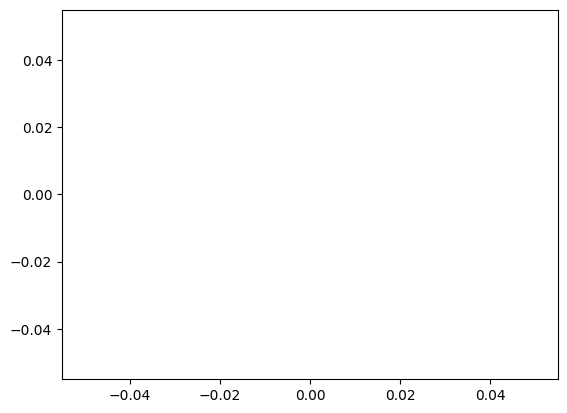

In [ ]:
plt.plot(loss_history)
plt.show()

In [ ]:
def run_test():
  environment, mapping_agent, drones = env_init(1)

  state = np.expand_dims(mapping_agent.map,axis=-1)
  dronePos = np.zeros((100, 100, 1))
  for d in drones:
    dronePos[d.y_odom, d.x_odom, 0] = 1
  nsteps = 0

  rewardTot = 0

  while True:

      # Predict action probabilities and estimated future rewards
      # from environment state
      Qs = qnetwork.predict([state[None,...], dronePos[None,...]])[0]

      # Sample action from action probability distribution
      action = np.argmax(np.squeeze(Qs))

      for d in drones:
        if action == 0:
          d.move([0, 1])
        if action == 1:
          d.move([0, -1])
        if action == 2:
          d.move([1, 0])
        if action == 3:
          d.move([-1, 0])

      # Apply the sampled action in our environment
      state = np.expand_dims(mapping_agent.map,axis=-1)
      dronePos = np.zeros((100, 100, 1))
      for d in drones:
        dronePos[d.y_odom, d.x_odom, 0] = 1
      reward = -compare_map_to_environment(mapping_agent, environment)

      rewardTot = reward

      # env.render(); # Adding this line would show the attempts
      # of the agent in a pop up window.
      # print('state',state,'action',action,'reward',reward,'done',done,'\n')

      nsteps += 1

      if nsteps > 300:
          break
  return rewardTot

print(np.mean([run_test() for i in range(2)]))


-3757.7943352095936
